In [62]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
smsspam = pd.read_csv('../data/smsspam.csv')
spam = pd.read_csv('../data/spam.csv')
tsp = pd.read_csv('../data/tsp.csv')

In [3]:
class GBayes:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        _data = x
        _data['label'] = y
        self.classes = np.unique(y)
        
        # prior
        self.class_probabilities = _data.groupby('label').size() / len(_data)
        
        # posterior
        self.means = _data.groupby('label').mean()
        self.std = _data.groupby('label').std()

    def calculate_probability(self, x, mean, std):
        exp = np.exp(-((x - mean) ** 2 / (2 * std ** 2)))
        if not exp:
            exp += 1e-5
        return (1 / (np.sqrt(2 * np.pi) * std)) * exp
    
    def class_probability_one(self, row):
        
        row_class = np.ones(len(self.classes))
        for cls in self.classes:
            for column in self.means:
                row_class[cls] *= self.calculate_probability(row[column], self.means.iloc[cls][column],
                                                             self.std.iloc[cls][column])
        return row_class
                
    def predict_row(self, x):
        pfc = self.class_probability_one(x)
        pcf = np.ones(len(self.classes))
        
        total_prob = (pfc * self.class_probabilities).sum()
        
        pcf = (pfc * self.class_probabilities) / total_prob
            
        prediction = pcf.argmax()
        if prediction < 0:
            prediction = np.random.randint(0, 2)

        return pfc, pcf, prediction
    
    def predict(self, x):
        y = []
        prob_1 = []
        for i in range(len(x)):
            pfc, pcf, prediction = self.predict_row(x.iloc[i])
            prob_1.append(pcf[1])
            y.append(prediction)
        return y, prob_1

In [4]:
def accuracy(y_pred, y_true):
    return (y_pred == y_pred).sum() / len(y_pred)

In [12]:
x, y = spam.drop('label', axis=1), spam.label
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train = pd.DataFrame(x_train, columns=spam.drop('label', axis=1).columns)
x_test = pd.DataFrame(x_test, columns=spam.drop('label', axis=1).columns)

In [13]:
gb = GBayes()

In [14]:
gb.fit(x_train, y_train)

In [15]:
y_pred, prob = gb.predict(x_test)

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

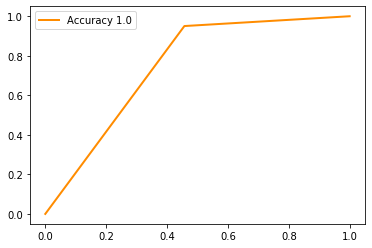

In [17]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Accuracy {accuracy(y_test, y_pred)}')
plt.legend()

In [120]:
class MBayes:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        self._data = x
        self._data['label'] = y
        self.classes = np.unique(y)
        
        self.n_doc = len(x)
        self.n_doc_c = self._data.groupby('label').size()
        self.prior = np.log(self.n_doc_c / self.n_doc)
        self.train()
        
    def tokenize(self, x):
        x = ' '.join([ps.stem(i.lower()) for i in x.split() if len(ps.stem(i.lower())) > 1])
        return x
        
    def train(self):
        self._data.text = self._data.text.apply(self.tokenize)
        self.vectorizer = CountVectorizer()
        self.vectorizer.fit_transform(self._data.text)
        self.vocab = self.vectorizer.get_feature_names()
        
        self.likelihood = {}
        for cls in self.classes:
            self.vectorizer = CountVectorizer()
            x = self.vectorizer.fit_transform(self._data.loc[self._data.label == cls].text)
            matrix = x.toarray()
            cls_vocab = self.vectorizer.get_feature_names()
            self.likelihood[cls] = {}
            for i, word in enumerate(cls_vocab):
                word_count = sum(matrix[:, i])
                self.likelihood[cls][word] = np.log((word_count + 1) / (matrix.sum() + len(self.vocab)))
                
    def predict_row(self, x):
        class_sum = np.zeros(len(self.classes))
        for i, cls in enumerate(self.classes):
            class_sum[i] = self.prior.loc[cls]
            for word in x.split():
                if word in self.vocab:
                    class_sum[i] += self.likelihood[cls][word]
        return class_sum, np.argmax(class_sum)
    
    def predict(self, x):
        y_pred = []
        probs = []
        for row in x.text:
            text = self.tokenize(row)
            y, p = self.predict_row(text)
            y_pred.append(y)
            probs.append(p)
        return y_pred, probs

In [121]:
x, y = smsspam.drop('label', axis=1), smsspam.label
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train = pd.DataFrame(x_train, columns=smsspam.drop('label', axis=1).columns)
x_test = pd.DataFrame(x_test, columns=smsspam.drop('label', axis=1).columns)

In [122]:
mb = MBayes()

In [ ]:
mb.fit(x_train, y_train)

In [ ]:
y_pred, prob = mb.predict(x_test)

In [ ]:
mb.likelihood

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Accuracy {accuracy(y_test, y_pred)}')
plt.legend()

In [ ]:
# Monte-Carlo

In [ ]:
class City:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city): # L_1 расстояние до города city
        x_dist = abs(self.x - city.x)
        y_dist = abs(self.y - city.y)
        dist = x_dist + y_dist
        return dist
    
    def __repr__(self): # привычное воспроизведение координат нашего города
        return '(' + str(self.x) + ', ' + str(self.y) + ')'

In [ ]:
class Fitness:
    
    def __init__(self, route):
        self.route = route # маршрут
        self.distance = 0 # длина маршрута
        self.fitness = 0 # величина, обратная длине маршрута
    
    def route_distance(self):
        if self.distance == 0:
            dist = 0
            for i in range(len(self.route) - 1):
                from_city = self.route[i]
                to_city = self.route[i + 1]
                dist += from_city.distance(to_city)
            self.distance = dist
        return self.distance
    
    def route_fitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.route_distance())
        return self.fitness

In [ ]:
def create_route(city_list): # создаём произвольный маршрут
    route = random.sample(city_list, len(city_list))
    return route

def create_many_routes(city_list, n):
    routes = []
    for i in range(n):
        routes.append(create_route(city_list))
    return routes

def rank_routes(routes, n): # ранжируем маршруты по величине fitness_route
    fitness_ranking = {}
    for i in range(n):
        fitness_ranking[i] = Fitness(routes[i]).route_fitness()
    return sorted(fitness_ranking.items(), key=operator.itemgetter(1), reverse=True)

def monte_carlo(city_list, num_iterations):
    routes = create_many_routes(city_list, num_iterations)
    ranked_routes = rank_routes(routes, num_iterations)
    best_route_index = ranked_routes[0][0]
    best_route = routes[best_route_index]
    print(f'Лучшее расстояние: {1 / ranked_routes[0][1]}')
    return best_route

def plot_best_path(best_route):
    for i in range(len(best_route)):
        if i < (len(best_route) - 1):
            x1, y1 = [best_route[i].x, best_route[i + 1].x], [best_route[i].y, best_route[i].y]
            x2, y2 = [best_route[i + 1].x, best_route[i + 1].x], [best_route[i].y, best_route[i + 1].y]
            plt.plot(x1, y1, color='red')
            plt.plot(x2, y2, color='red')
        plt.scatter(best_route[0].x, best_route[0].y, color='blue', s=60)
        plt.scatter(best_route[-1].x, best_route[-1].y, color='blue', s=60)
        if i != 0 and i != len(best_route) - 1:
            plt.scatter(best_route[i].x, best_route[i].y, color='black')

In [ ]:
city_list = []
for i in range(len(X)):
    city_list.append(City(x=X[i], y=Y[i]))

In [ ]:
best_route = monte_carlo(city_list, 1000)

In [ ]:
plot_best_path(best_route)